In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'phishing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4918846%2F8282289%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T093403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2c581100e01b2e7a72020f8a9aa60c8e6968d4f0e6e3e89508bfddf36ce686d21fd37a01ab8510759266714e45634d30809e943419ad77477d15217dcd00706b8b0fb693c0be3c3b047ab0a104793023434e436ffed2d274f451cc69b6ea1721012012d4611cd92831276b2d14074a15348863fc0e8e049eb9282b95c661a1a347d975dcbe640b61ba8e522ec4871f8d0dcd1f98004b571defe223ba195c60638fd8f109946513c40704c84aea2cefd67817718aa0869c27c0f6356f5d5df5856541fa5a51c5172ae8f5f128c58766fbc5d4c2d04041ac56489105f3b1d55cf6a76a3676955563497a4249e8f45bae2fa20f3de14ec6b4c236c0245573900b0d,phishing-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4938883%2F8314101%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T093403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a2351c3d0831bafd5e45bd720588970c4c4cd0b1b3c930762c1f9ec5c45fac7613d011d3830e5074e2f4bc4b89e875733187e961eeafc2e8a280b10f5e95ae07ae12f317a1befa206d6654f31a4a8b482e72f34ed06763e5adaca16a4f13dd888430a9b2b46ea2c4129e873084155422ea8a1761e7d06b10a8b62b84f937e29315d8e9ee1fd0afc5bf3c58c49dacc1e4a075d63c6c34b34b9f5a224c698ecfad15dfcc074a401db6a06ca8fdc26b51cf3cde45bd46917af6dd35ec3ad8e796ed329a077abbed44119c8f488333a2b950ab685a32d215f4783294812d69c0992a7398d1b03008901a481323649db84de3dc5b18de11509056f27055c86166596,model/pytorch/model2/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F35758%2F42553%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T093403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2fb6284952e26fefd42fcf47e414a3c9125644fe7764b40b93198f185f98cb94df93353ee208e3a723f5f05ff427f5ff9c3ef7f21c8e7b01fe12843516a07de84c3dbd191b4de0d7a81ff50737e0b4b9534eba75532eabf517411a461e0df38c996a7ba8d86bd84d45b1f970cc0f75e231de64f9067db06a49adb5a8bc8740eb6bc5033f847a5e9e182ebca7c849763794d1765f435bb924371fa1329232948234752b931fd3c09168abf6eaa4c1b1d9e15b30d9793e1839cfef82a9c2b5b6d8986bbdb3030b3efdb348511e0ab2eb267e803928838818d8432462df3add68765de60f4068a45055db6c7dba8e1501ffd071888d2cb0dbfc6b3441622f7f0881'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [ ]:
data = pd.read_csv('/kaggle/input/phishing-data/Phishing_Legitimate_full.csv')
data.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [ ]:
data.dtypes

id                                      int64
NumDots                                 int64
SubdomainLevel                          int64
PathLevel                               int64
UrlLength                               int64
NumDash                                 int64
NumDashInHostname                       int64
AtSymbol                                int64
TildeSymbol                             int64
NumUnderscore                           int64
NumPercent                              int64
NumQueryComponents                      int64
NumAmpersand                            int64
NumHash                                 int64
NumNumericChars                         int64
NoHttps                                 int64
RandomString                            int64
IpAddress                               int64
DomainInSubdomains                      int64
DomainInPaths                           int64
HttpsInHostname                         int64
HostnameLength                    

In [ ]:
data.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,...,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,...,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10000.00000,21.000000,14.000000,18.000000,253.000000,55.000000,9.000000,1.000000,1.000000,18.00000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data = shuffle(data)
threshold = 0.9 * len(data)
data.dropna(thresh=threshold, axis=1)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
8096,8097,1,0,3,76,5,0,0,0,0,...,1,0,0,1,-1,-1,1,0,1,0
985,986,3,1,1,40,0,0,0,0,0,...,0,0,0,1,1,1,1,1,-1,1
1702,1703,3,0,4,59,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
7143,7144,3,1,5,120,12,0,0,0,0,...,0,0,0,1,-1,1,1,1,0,0
1417,1418,2,1,2,57,1,1,0,0,0,...,0,0,0,1,0,1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,7632,1,0,5,70,5,0,0,0,0,...,1,0,0,1,0,-1,0,-1,0,0
5640,5641,2,0,7,90,0,0,0,0,0,...,0,0,0,1,-1,1,0,0,1,0
7210,7211,3,0,1,74,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
8309,8310,1,0,4,50,2,0,0,0,0,...,1,0,0,1,1,-1,0,0,1,0


In [ ]:
X = data.drop(columns=['id', 'CLASS_LABEL'])
y = data['CLASS_LABEL']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, latent_dim * 2)

    def forward(self, x):
        x = self.fc(x)
        mu, log_var = x.chunk(2, dim=-1)
        return mu, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        x_hat = self.fc(z)
        return x_hat

# CVAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def loss_function(x, x_hat, mu, log_var):
    recon_loss = nn.BCEWithLogitsLoss(reduction='sum')
    BCE = recon_loss(x_hat, x)  # Reconstruction loss

    # Compute KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    KLD /= x.size(0)

    return BCE + KLD

In [ ]:
features, labels = X, y
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)
print(features_tensor.shape)
print(labels_tensor.shape)

# print(features)
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialization of model
input_dim = features.shape[1]
latent_dim = 16
vae_model = VAE(input_dim, latent_dim)
print(vae_model)
# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(vae_model.parameters(), lr=0.00001, weight_decay=0.001)  # Weight decay of 0.001
epochs = 65

for epoch in range(epochs):
    running_loss = 0.0
    for batch in tqdm(dataloader):
        x, _ = batch
        optimizer.zero_grad()
        x_hat, mu, log_var = vae_model(x)
        loss = loss_function(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

torch.Size([10000, 48])
torch.Size([10000])
VAE(
  (encoder): Encoder(
    (fc): Linear(in_features=48, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=16, out_features=48, bias=True)
  )
)


100%|██████████| 313/313 [00:00<00:00, 429.58it/s]


Epoch 1, Loss: 1171.6941153919354


100%|██████████| 313/313 [00:00<00:00, 521.04it/s]


Epoch 2, Loss: 1156.9670610031762


100%|██████████| 313/313 [00:00<00:00, 522.52it/s]


Epoch 3, Loss: 1142.8202930487003


100%|██████████| 313/313 [00:00<00:00, 525.44it/s]


Epoch 4, Loss: 1131.3102372142073


100%|██████████| 313/313 [00:00<00:00, 519.38it/s]


Epoch 5, Loss: 1114.601263064546


100%|██████████| 313/313 [00:00<00:00, 534.99it/s]


Epoch 6, Loss: 1106.8557192281412


100%|██████████| 313/313 [00:00<00:00, 538.60it/s]


Epoch 7, Loss: 1092.3237417787789


100%|██████████| 313/313 [00:00<00:00, 543.46it/s]


Epoch 8, Loss: 1084.559833953175


100%|██████████| 313/313 [00:00<00:00, 498.64it/s]


Epoch 9, Loss: 1067.7715810952477


100%|██████████| 313/313 [00:00<00:00, 532.38it/s]


Epoch 10, Loss: 1058.3717404691556


100%|██████████| 313/313 [00:00<00:00, 537.19it/s]


Epoch 11, Loss: 1041.6937388459714


100%|██████████| 313/313 [00:00<00:00, 511.31it/s]


Epoch 12, Loss: 1024.9610815566189


100%|██████████| 313/313 [00:00<00:00, 523.86it/s]


Epoch 13, Loss: 1019.9196775393744


100%|██████████| 313/313 [00:00<00:00, 532.63it/s]


Epoch 14, Loss: 999.8105508968853


100%|██████████| 313/313 [00:00<00:00, 528.13it/s]


Epoch 15, Loss: 985.8395169779135


100%|██████████| 313/313 [00:00<00:00, 538.19it/s]


Epoch 16, Loss: 977.2670653711873


100%|██████████| 313/313 [00:00<00:00, 536.24it/s]


Epoch 17, Loss: 961.3770443852336


100%|██████████| 313/313 [00:00<00:00, 539.77it/s]


Epoch 18, Loss: 950.1790817309492


100%|██████████| 313/313 [00:00<00:00, 532.97it/s]


Epoch 19, Loss: 935.6544546304038


100%|██████████| 313/313 [00:00<00:00, 532.21it/s]


Epoch 20, Loss: 927.6045049600327


100%|██████████| 313/313 [00:00<00:00, 525.82it/s]


Epoch 21, Loss: 908.792967945623


100%|██████████| 313/313 [00:00<00:00, 519.28it/s]


Epoch 22, Loss: 891.5482429285018


100%|██████████| 313/313 [00:00<00:00, 522.27it/s]


Epoch 23, Loss: 877.6970972420689


100%|██████████| 313/313 [00:00<00:00, 518.78it/s]


Epoch 24, Loss: 864.1115423817985


100%|██████████| 313/313 [00:00<00:00, 446.15it/s]


Epoch 25, Loss: 853.2075212131293


100%|██████████| 313/313 [00:00<00:00, 512.52it/s]


Epoch 26, Loss: 833.802302948583


100%|██████████| 313/313 [00:00<00:00, 530.13it/s]


Epoch 27, Loss: 818.5124190699178


100%|██████████| 313/313 [00:00<00:00, 528.06it/s]


Epoch 28, Loss: 806.4781327658949


100%|██████████| 313/313 [00:00<00:00, 525.06it/s]


Epoch 29, Loss: 790.1329699629031


100%|██████████| 313/313 [00:00<00:00, 504.53it/s]


Epoch 30, Loss: 773.4609158549446


100%|██████████| 313/313 [00:00<00:00, 528.84it/s]


Epoch 31, Loss: 752.2361125885108


100%|██████████| 313/313 [00:00<00:00, 504.70it/s]


Epoch 32, Loss: 741.17002347026


100%|██████████| 313/313 [00:00<00:00, 520.09it/s]


Epoch 33, Loss: 724.4388548634685


100%|██████████| 313/313 [00:00<00:00, 527.65it/s]


Epoch 34, Loss: 706.9298025502945


100%|██████████| 313/313 [00:00<00:00, 514.05it/s]


Epoch 35, Loss: 686.6487157900874


100%|██████████| 313/313 [00:00<00:00, 515.35it/s]


Epoch 36, Loss: 673.0745838153096


100%|██████████| 313/313 [00:00<00:00, 512.47it/s]


Epoch 37, Loss: 657.7368934314471


100%|██████████| 313/313 [00:00<00:00, 520.80it/s]


Epoch 38, Loss: 636.0982928900673


100%|██████████| 313/313 [00:00<00:00, 524.22it/s]


Epoch 39, Loss: 620.3479092387727


100%|██████████| 313/313 [00:00<00:00, 516.81it/s]


Epoch 40, Loss: 597.969441398645


100%|██████████| 313/313 [00:00<00:00, 533.41it/s]


Epoch 41, Loss: 582.4855967756278


100%|██████████| 313/313 [00:00<00:00, 493.01it/s]


Epoch 42, Loss: 564.8609367589982


100%|██████████| 313/313 [00:00<00:00, 533.23it/s]


Epoch 43, Loss: 544.90417577969


100%|██████████| 313/313 [00:00<00:00, 529.35it/s]


Epoch 44, Loss: 526.0579946597163


100%|██████████| 313/313 [00:00<00:00, 530.14it/s]


Epoch 45, Loss: 507.67171407583805


100%|██████████| 313/313 [00:00<00:00, 488.02it/s]


Epoch 46, Loss: 485.3827150180317


100%|██████████| 313/313 [00:00<00:00, 515.83it/s]


Epoch 47, Loss: 468.38033057020874


100%|██████████| 313/313 [00:00<00:00, 487.88it/s]


Epoch 48, Loss: 450.15488722073


100%|██████████| 313/313 [00:00<00:00, 527.35it/s]


Epoch 49, Loss: 422.98061972304276


100%|██████████| 313/313 [00:00<00:00, 518.43it/s]


Epoch 50, Loss: 405.51201539450943


100%|██████████| 313/313 [00:00<00:00, 508.29it/s]


Epoch 51, Loss: 382.7768383696437


100%|██████████| 313/313 [00:00<00:00, 521.79it/s]


Epoch 52, Loss: 364.5430683099424


100%|██████████| 313/313 [00:00<00:00, 526.14it/s]


Epoch 53, Loss: 341.3358552097893


100%|██████████| 313/313 [00:00<00:00, 509.76it/s]


Epoch 54, Loss: 317.013850397957


100%|██████████| 313/313 [00:00<00:00, 513.64it/s]


Epoch 55, Loss: 295.88096131151093


100%|██████████| 313/313 [00:00<00:00, 515.36it/s]


Epoch 56, Loss: 270.91007036446763


100%|██████████| 313/313 [00:00<00:00, 512.44it/s]


Epoch 57, Loss: 260.4477767761523


100%|██████████| 313/313 [00:00<00:00, 490.71it/s]


Epoch 58, Loss: 233.65902960414704


100%|██████████| 313/313 [00:00<00:00, 522.74it/s]


Epoch 59, Loss: 211.22343853106514


100%|██████████| 313/313 [00:00<00:00, 506.46it/s]


Epoch 60, Loss: 190.6661555866083


100%|██████████| 313/313 [00:00<00:00, 507.72it/s]


Epoch 61, Loss: 170.61626802389614


100%|██████████| 313/313 [00:00<00:00, 524.52it/s]


Epoch 62, Loss: 149.24040448246672


100%|██████████| 313/313 [00:00<00:00, 530.32it/s]


Epoch 63, Loss: 127.47203261402849


100%|██████████| 313/313 [00:00<00:00, 530.34it/s]


Epoch 64, Loss: 101.46090745468871


100%|██████████| 313/313 [00:00<00:00, 526.85it/s]

Epoch 65, Loss: 74.46402628962605


In [ ]:
num_samples = 1500
sample_indices = np.random.choice(len(X), num_samples, replace=False)
sampled_data = X[sample_indices]
sampled_labels = y.iloc[sample_indices]

# 2. Prepare the data for the CVAE
input_data = torch.tensor(sampled_data, dtype=torch.float32)
original_labels = torch.tensor(sampled_labels.values, dtype=torch.float32)

features_tensor = torch.tensor(input_data, dtype=torch.float32)
labels_tensor = torch.tensor(original_labels, dtype=torch.float32)

# Create dataset and data loader
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

synthetic_samples = []
synthetic_labels = []

for batch_data, batch_labels in tqdm(dataloader):
    batch_labels = batch_labels.unsqueeze(1)
    recon_batch, mu, log_var = vae_model(batch_data)
    synthetic_samples.append(recon_batch)
    synthetic_labels.append(batch_labels)
synthetic_samples = torch.cat(synthetic_samples, dim=0)
synthetic_labels = torch.cat(synthetic_labels, dim=0)

/tmp/ipykernel_33/512837805.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(input_data, dtype=torch.float32)
/tmp/ipykernel_33/512837805.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(original_labels, dtype=torch.float32)
100%|██████████| 47/47 [00:00<00:00, 1557.69it/s]


In [ ]:
torch.save(vae_model.state_dict(), '/kaggle/working/feature_extraction_model.pth')

In [ ]:
synthetic_samples_np = synthetic_samples.detach().cpu().numpy()
synthetic_labels_np = synthetic_labels.detach().cpu().numpy()
synthetic_labels_np = np.squeeze(synthetic_labels_np)

X = np.concatenate((X, synthetic_samples_np), axis=0)
y = np.concatenate((y, synthetic_labels_np), axis=0)
print(X.shape)
print(y.shape)

(11500, 48)
(11500,)


In [ ]:
def extract_features(model, new_data):
  with torch.no_grad():
    new_data_tensor = torch.tensor(new_data, dtype=torch.float32)
    latent_features = model.encoder(new_data_tensor)
  return latent_features[0]
extracted_features = []
for data_point in X:
  latent_features = extract_features(vae_model, data_point)
  extracted_features.append(latent_features)
X_extracted = np.array(extracted_features)
print(X_extracted.shape)

(11500, 16)


In [ ]:
print(X_extracted)

[[-0.6962614  -0.48135972 -0.1324688  ... -0.65026623 -1.558689
  -0.87376964]
 [ 1.6850976   2.3672192  -1.4620941  ...  1.3632189   0.49202505
   0.13247415]
 [ 0.3937574   1.0222331  -0.34166455 ...  0.483559    1.1307237
   0.85962546]
 ...
 [ 5.793721    2.8989217  -3.660188   ... -2.6970627  -4.715182
   2.6458468 ]
 [ 4.7241507   2.767317   -2.5526762  ...  2.5848608  -3.0519307
  -1.7957351 ]
 [ 7.323647    4.1191454  -5.050773   ...  5.2162805  -1.6692485
  -4.2648582 ]]


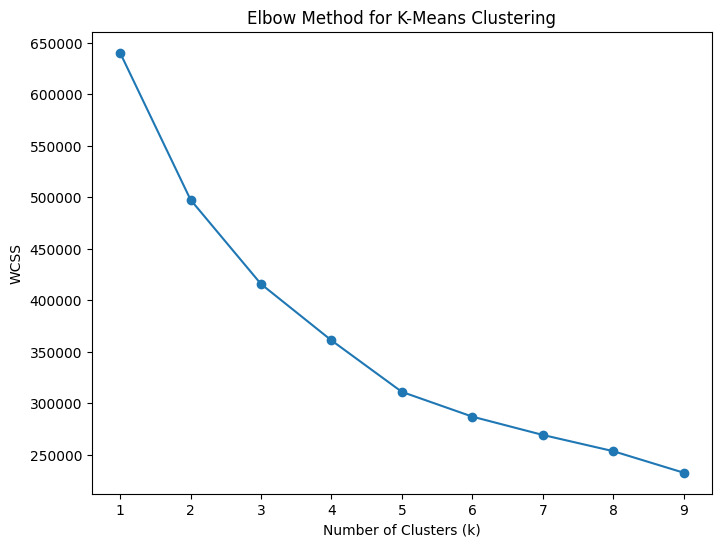

In [ ]:
k_range = range(1, 10)  # Adjust the range based on your data
wcss = []
for k in k_range:
  kmeans = KMeans(n_clusters=k, n_init='auto')
  kmeans.fit(extracted_features)  # Replace with your extracted features
  wcss.append(kmeans.inertia_)  # Inertia_ attribute stores WCSS
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for K-Means Clustering")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, n_init='auto')
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(extracted_features)
kmeans.fit(reduced_features)
cluster_labels = kmeans.labels_

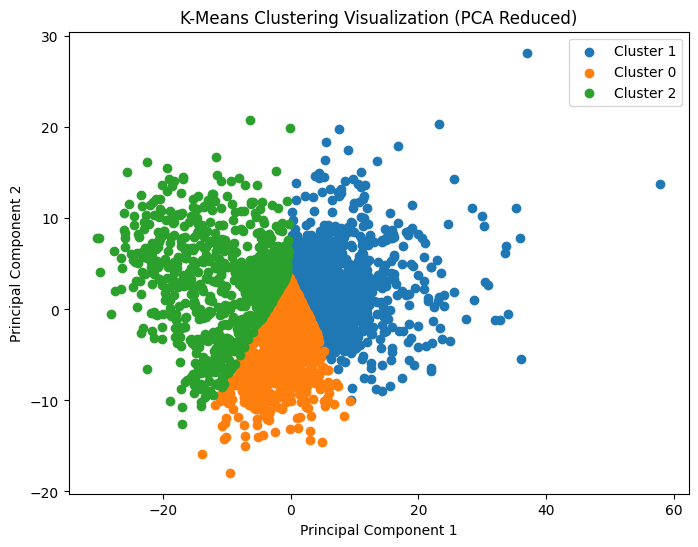

In [ ]:
cluster_data = {}
for i, data_point in enumerate(reduced_features):
    cluster = cluster_labels[i]
    if cluster not in cluster_data:
        cluster_data[cluster] = []
    cluster_data[cluster].append(data_point)
cluster_features = {cluster: np.array(data) for cluster, data in cluster_data.items()}

plt.figure(figsize=(8, 6))
for cluster, features in cluster_features.items():
    plt.scatter(features[:, 0], features[:, 1], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.legend()
plt.show()

In [ ]:
silhouette_score(reduced_features, cluster_labels)

0.3753982824136844

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_extracted, y, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8625, 16) (8625,) (2875, 16) (2875,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cardinality):
        super(ResNeXtBlock, self).__init__()
        self.cardinality = cardinality
        self.conv1x1_layers = nn.ModuleList([nn.Conv1d(out_channels, out_channels, kernel_size=1) for _ in range(cardinality)])
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(out_channels) for _ in range(cardinality)])

    def forward(self, x):
        outputs = []
        for i in range(self.cardinality):
            out = self.conv1x1_layers[i](x)
            out = self.bn_layers[i](out)
            out = F.relu(out)
            outputs.append(out)
        return torch.cat(outputs, dim=1)

class ResNeXtGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, cardinality=16):
        super(ResNeXtGRU, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.block1 = ResNeXtBlock(64, 64, cardinality)
        self.gru = nn.GRU(input_size=64 * cardinality, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.block1(out)
        out = out.permute(0, 2, 1)  # Change dimensions for GRU
        out, _ = self.gru(out)
        out = out[:, -1, :]  # Take only the last timestep's output
        out = self.fc(out)
        return out

# Example usage:
input_size = 16  # Number of input features
hidden_size = 128  # Size of the hidden state in GRU
num_classes = 2  # Number of output classes
model = ResNeXtGRU(input_size, hidden_size, num_classes)
print(model)

ResNeXtGRU(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (block1): ResNeXtBlock(
    (conv1x1_layers): ModuleList(
      (0-15): 16 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (bn_layers): ModuleList(
      (0-15): 16 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gru): GRU(1024, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.long)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
num_epochs = 200

X_train_tensor = X_train_tensor.unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics every few iterations
        if i % 118 == 117:
            avg_loss = running_loss / 100
            accuracy = (correct / total) * 100
            print(f'Epoch [{epoch+1}/{num_epochs}],'f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

# After training completes, you can print the final accuracy on the training data
train_accuracy = (correct / total) * 100
print(f'Training Accuracy: {train_accuracy:.2f}%')

Epoch [1/200],Loss: 0.4205, Accuracy: 84.81%
Epoch [2/200],Loss: 0.3523, Accuracy: 87.33%
Epoch [3/200],Loss: 0.3176, Accuracy: 88.81%
Epoch [4/200],Loss: 0.2907, Accuracy: 89.71%
Epoch [5/200],Loss: 0.2720, Accuracy: 90.85%
Epoch [6/200],Loss: 0.2561, Accuracy: 91.14%
Epoch [7/200],Loss: 0.2468, Accuracy: 91.64%
Epoch [9/200],Loss: 0.2176, Accuracy: 92.48%
Epoch [10/200],Loss: 0.2015, Accuracy: 92.98%
Epoch [11/200],Loss: 0.2000, Accuracy: 93.14%
Epoch [12/200],Loss: 0.1905, Accuracy: 93.41%
Epoch [13/200],Loss: 0.1751, Accuracy: 93.98%
Epoch [14/200],Loss: 0.1615, Accuracy: 94.44%
Epoch [15/200],Loss: 0.1673, Accuracy: 94.15%
Epoch [16/200],Loss: 0.1549, Accuracy: 94.48%
Epoch [17/200],Loss: 0.1516, Accuracy: 94.81%
Epoch [18/200],Loss: 0.1289, Accuracy: 95.62%
Epoch [19/200],Loss: 0.1185, Accuracy: 96.11%
Epoch [20/200],Loss: 0.1386, Accuracy: 95.15%
Epoch [21/200],Loss: 0.1219, Accuracy: 95.90%
Epoch [22/200],Loss: 0.1162, Accuracy: 96.16%
Epoch [23/200],Loss: 0.0975, Accuracy: 96.

In [ ]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics
print(f'Accuracy: {(correct/total)*100:.2f}%')

Accuracy: 91.83%


Accuracy: 91.44%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


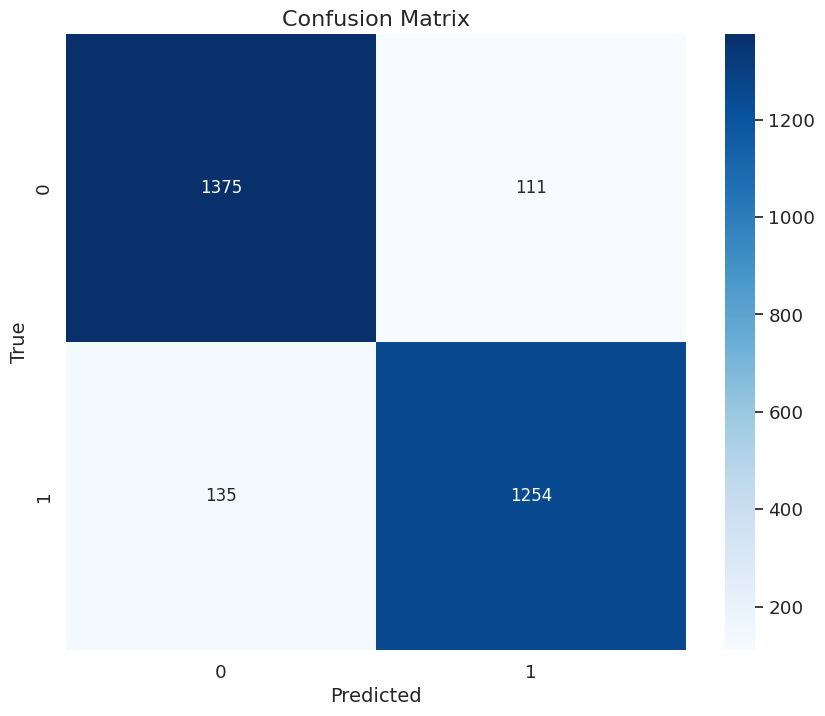

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

val_loss = 0.0
correct = 0
total = 0
predicted_all = []
labels_all = []

# Confusion matrix
conf_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predictions and labels for confusion matrix
        predicted_all.extend(predicted.tolist())
        labels_all.extend(labels.tolist())

    # Compute precision, recall, and F1 score
    precision = precision_score(labels_all, predicted_all, average='weighted')
    recall = recall_score(labels_all, predicted_all, average='weighted')
    f1 = f1_score(labels_all, predicted_all, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels_all, predicted_all)

# Print statistics
print(f'Accuracy: {(correct / total) * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print confusion matrix as a colorful table
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})  # font size
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [ ]:
torch.save(model.state_dict(), '/kaggle/working/final_model.pth')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assuming model, X_train, X_test, y_train, y_test are defined previously

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

X_train_tensor = X_train_tensor.unsqueeze(1)

criterion = nn.CrossEntropyLoss()

batch_size = 64
num_epochs = 3

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

def evaluate_loss(params):
    data, target = next(iter(train_loader))
    output = model(data)
    loss = criterion(output, target)
    return loss.item()  # Return the scalar value of the loss

# Define lower and upper bounds for JayaOptimizer
lower_bound = np.array([-1000] * 512386)
upper_bound = np.array([1000] * 512386)

# Initialize the JayaOptimizer
optimizer = JayaOptimizer(f=evaluate_loss, lower_bound=lower_bound, upper_bound=upper_bound)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for i, (data, target) in enumerate(train_loader):
        new_params = optimizer.next()[0]  # Update JayaOptimizer's population and fitness
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        total_param_size = sum(p.numel() for p in model.parameters())
        new_params = new_params.reshape(total_param_size)
        start = 0
        for param in model.parameters():
          param_update = torch.tensor(new_params[start:start + param.numel()]).view(param.shape)  # Create tensor
          # print("Before update:", param.data)
          # print("Updated: ", param_update)
          param.data.copy_(param_update)  # Update parameter tensor's data attribute
          # print("After update:", param.data)
          start += param.numel()
        # print(i," ",data.shape)
        if (i + 1) % len(train_loader) == 0:  # Print every epoch
            print(model.parameters())
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}]: Loss: {loss.item():.4f}')

In [ ]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics
print(f'Accuracy: {(correct/total)*100:.2f}%')

In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier

SENSITIVE_WORDS = ['secure', 'account', 'webscr', 'login',
'ebayisapi', 'signin', 'banking', 'confirm']

def count_sensitive_words(url):
    num_sensitive_words = 0
    for word in SENSITIVE_WORDS:
        if word in url.lower():
            num_sensitive_words += 1
    return num_sensitive_words

def extract_features_from_url(url):
    features = {}
    parsed_url = urlparse(url)

    # Feature extraction
    features[0] = url.count('.')
    features[1] = url.count('.') - 1
    features[2] = url.count('/')-2
    features[3] = len(url)
    features[4] = url.count('-')
    features[5] = parsed_url.netloc.count('-')
    features[6] = url.count('@')
    features[7] = url.count('~')
    features[8] = url.count('_')
    features[9] = url.count('%')
    features[10] = len(parsed_url.query.split('&'))
    features[11] = url.count('&')
    features[12] = url.count('#')
    features[13] = sum(c.isdigit() for c in url)
    features[14] = 1 if parsed_url.scheme != 'https' else 0
    features[15] = 1 if re.search(r'\d{5,}', url) else 0
    features[16] = 1 if re.match(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', parsed_url.netloc) else 0 #ip addr instead of domain name
    features[17] = url.count(parsed_url.netloc) - 1 #no of subdomains
    features[18] = url.count(parsed_url.netloc)
    features[19] = 1 if 'https' in parsed_url.netloc else 0
    features[20] = len(parsed_url.netloc)
    features[21] = len(parsed_url.path)
    features[22] = len(parsed_url.query)
    features[23] = 1 if '//' in parsed_url.path else 0
    features[24] = count_sensitive_words(url)
    return features

url = "https://example.com/path/to/example/page?query=example"
features = extract_features_from_url(url)
f = np.array(list(features.values()))
d = pd.read_csv('/kaggle/input/phishing/Phishing_Legitimate_full.csv')
d = d.drop(columns = ["id", "CLASS_LABEL"])

k = 5
d_train = d.iloc[:, :25]
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(d_train, d.iloc[:, 25])
neighbors = knn.kneighbors(f.reshape(1, -1))
indices = neighbors[1][0]

for i in range(25, 48):
    neighbors_features = []
    for index in indices:
        neighbors_features.append(d.iloc[index, i])
    if i in [26, 27, 33]:
        features[i] = np.mean(neighbors_features)
    else:
        features[i] = mode(neighbors_features).mode
final_features = np.array(list(features.values()))
print(final_features)
print(final_features.shape)

[ 1.          0.          4.         54.          0.          0.

  0.          0.          0.          0.          1.          0.

  0.          0.          0.          0.          0.          0.

  1.          0.         11.         21.         13.          0.

  0.          0.          0.31326697  0.47232143  0.          1.

  0.          0.          0.          0.          0.          0.

  0.          0.          0.          0.          0.          0.

  1.          0.          1.          1.         -1.          0.        ]

(48,)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

  warnings.warn(
